<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/experience_replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training with experience replay
- Play game, sample <s,a,r,s'>.

- Update q-values based on <s,a,r,s'>.

- Store <s,a,r,s'> transition in a buffer.

- If buffer is full, delete earliest data.

Sample K such transitions from that buffer and update q-values based on them.

To enable such training, first we must implement a memory structure that would act like such a buffer.


In [65]:
# In google collab, uncomment this:
!wget https://bit.ly/2FMJP5K -q -O setup.py
!bash setup.py 2>&1 1>stdout.log | tee stderr.log

# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

--2019-09-18 16:24:27--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [text/plain]
Saving to: ‘../xvfb’

     0K                                                       100%  179M=0s

2019-09-18 16:24:27 (179 MB/s) - ‘../xvfb’ saved [640/640]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import random
import queue


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = queue.Queue()
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return self._storage.qsize()

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        if self._storage.qsize() < self._maxsize:
          self._storage.put(data)
        else:
          self._storage.get()
          self._storage.put(data)
          #print("size={0}".format(self._storage.qsize()))


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        #idxes = <randomly generate batch_size integers to be used as indexes of samples >

        # collect <s,a,r,s',done> for each index
        if batch_size > self._storage.qsize():
          batch_size = self._storage.qsize()
        samples = random.sample(self._storage.queue, batch_size)
        states = [i[0] for i in samples]
        actions = [i[1] for i in samples]
        rewards = [i[2] for i in samples]
        next_states = [i[3] for i in samples]
        is_dones = [i[4] for i in samples]


        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_dones)

In [67]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(
    1) == obj2sampled(obj1), "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


*利用experience_replay的方法，改善训练*

In [0]:
import gym
##上传qlearning.py到colab的文件中
from qlearning import QLearningAgent

env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [0]:
def play_and_train_with_replay(env, agent, replay=None, t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        agent.update(s, a, r, next_s)

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            replay.add(s, a, r, next_s, done)

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(min(replay_batch_size,len(s_))):
              if not done_[i]:
                agent.update(s_[i], a_[i], r_[i], next_s_[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [0]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                                get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.8610189229184374e-05 mean reward = 7.4
ExpReplay: eps = 2.8610189229184374e-05 mean reward = 9.0


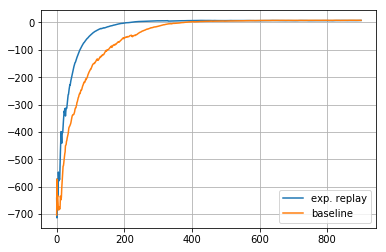

In [73]:

from IPython.display import clear_output
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(
        env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

如果实现正确，experience replay 将会提升算法的收敛速度，但是不会影响最终的结果。